In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
data0 = pd.read_csv('dataset.csv')
data = data0.copy()
data.head()

,NumHAcceptors,NumHDonors,alkyl_num,frag_sym,HOMO_calc,LUMO_calc,dipole,MPI,surface_min,surface_max,...,anchor_end_PO,anchor_end_SA,anchor_end_SH,anchor_end_SiO,MetalOxide_ITO,MetalOxide_NiOx,MetalOxide_SnO2,MetalOxide_TiO2,MetalOxide_ZnO,PCE
0,2,2,2,1,-5.665071,-1.022318,1.975439,11.42494,-38.62844,53.933991,...,0,0,0,0,0,1,0,0,0,22.40
1,4,2,2,1,-5.146211,-1.007550,1.467697,12.11600,-39.79595,52.674270,...,0,0,0,0,0,1,0,0,0,21.00
2,4,2,4,1,-5.182687,-1.386859,2.954174,12.05384,-40.46879,51.108000,...,0,0,0,0,0,1,0,0,0,25.60
3,3,1,0,0,-8.070575,-1.975575,6.131034,17.92665,-35.95829,45.147690,...,0,1,0,0,0,0,0,1,0,16.54
4,3,1,0,0,-7.655580,-1.919355,3.424702,15.53109,-31.70790,57.597300,...,0,1,0,0,0,0,0,1,0,16.88


In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
from sklearn.model_selection import ShuffleSplit,GridSearchCV, KFold
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

C:\Users\A\AppData\Local\Temp\ipykernel_20676\140680766.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.37881491  0.83756324  0.83756324  0.22937417  0.22937417 -0.98700399
 -0.37881491 -0.37881491 -0.37881491 -0.37881491 -0.37881491 -0.98700399
 -0.37881491 -0.37881491 -0.98700399 -0.98700399 -0.37881491 -0.37881491
 -0.37881491 -0.98700399 -0.98700399 -0.98700399 -0.37881491 -0.98700399
 -0.98700399  2.66213048  0.83756324  0.83756324 -0.98700399 -0.98700399
 -0.37881491 -0.37881491  0.22937417  0.83756324  1.44575232 -0.37881491
 -0.37881491 -0.37881491 -0.37881491  0.22937417  2.0539414   2.0539414
 -0.98700399  0.83756324  0.22937417  0.22937417  0.22937417 -0.37881491
  0.22937417  0.22937417  0.22937417  2.0539414  -0.37881491 -0.37881491
 -0.37881491 -0.98700399  2.0539414  -0.37881491 -0.37881491 -0.37881491
 -0.37881491  0.22937417 -0.37881491  0.22937417  0.22937417 -0.37881491
 -0.37881491 -0.37

In [3]:
# Xgboost and SHAP
import xgboost as xgb
param_test1 =  {'learning_rate': [0.05,0.075],
              'n_estimators': [150],
              'max_depth': [2, 3,5], 
              'min_child_weight': [2], 
              'subsample': [0.6],
              'colsample_bytree': [0.6],
              'gamma': [0.1], 
               'reg_alpha': [0.05], 
               'reg_lambda': [0.01],
   }
other_params={'objective': 'reg:squarederror',
              'seed': 0,
    }
model = xgb.sklearn.XGBRegressor(**other_params)
gsearch=GridSearchCV(model,param_grid=param_test1, scoring='neg_mean_squared_error',cv=10,n_jobs=8,verbose=4)
gsearch.fit(x, y)
xgb_model = gsearch.best_estimator_
print(gsearch.best_score_)
print(gsearch.best_params_)
print(f"RMSE: {np.sqrt(mean_squared_error(y, xgb_model.predict(x)))}")
print(f"r: {stats.pearsonr(y, xgb_model.predict(x))[0]}")


Fitting 10 folds for each of 6 candidates, totalling 60 fits
-2.3256269582032116
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.075, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 150, 'reg_alpha': 0.05, 'reg_lambda': 0.01, 'subsample': 0.6}
RMSE: 0.708679706254757
r: 0.9814352472986394


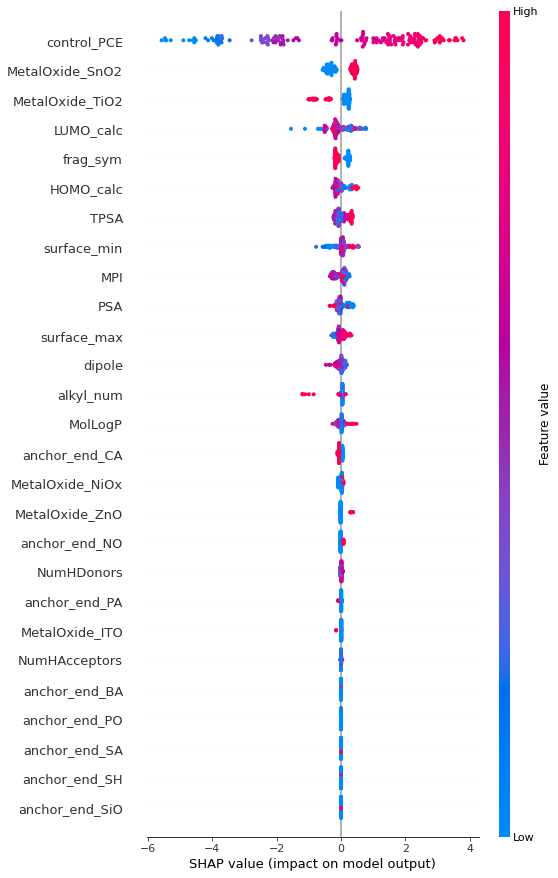

In [4]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_value = explainer.shap_values(x)
# print(shap_value.shape)
shap.summary_plot(shap_value,x,max_display=30,show=False)
plt.rcParams.update({
    'figure.figsize': (10, 12),
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'lines.linewidth': 0.75,
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'svg.fonttype': 'none',
    'figure.dpi': 300,
})
ax = plt.gca()
plt.show()
# ax.get_figure().savefig('shap1.svg', format='svg', dpi=300)
# ax.get_figure().savefig('shap30.svg', format='svg', dpi=300)

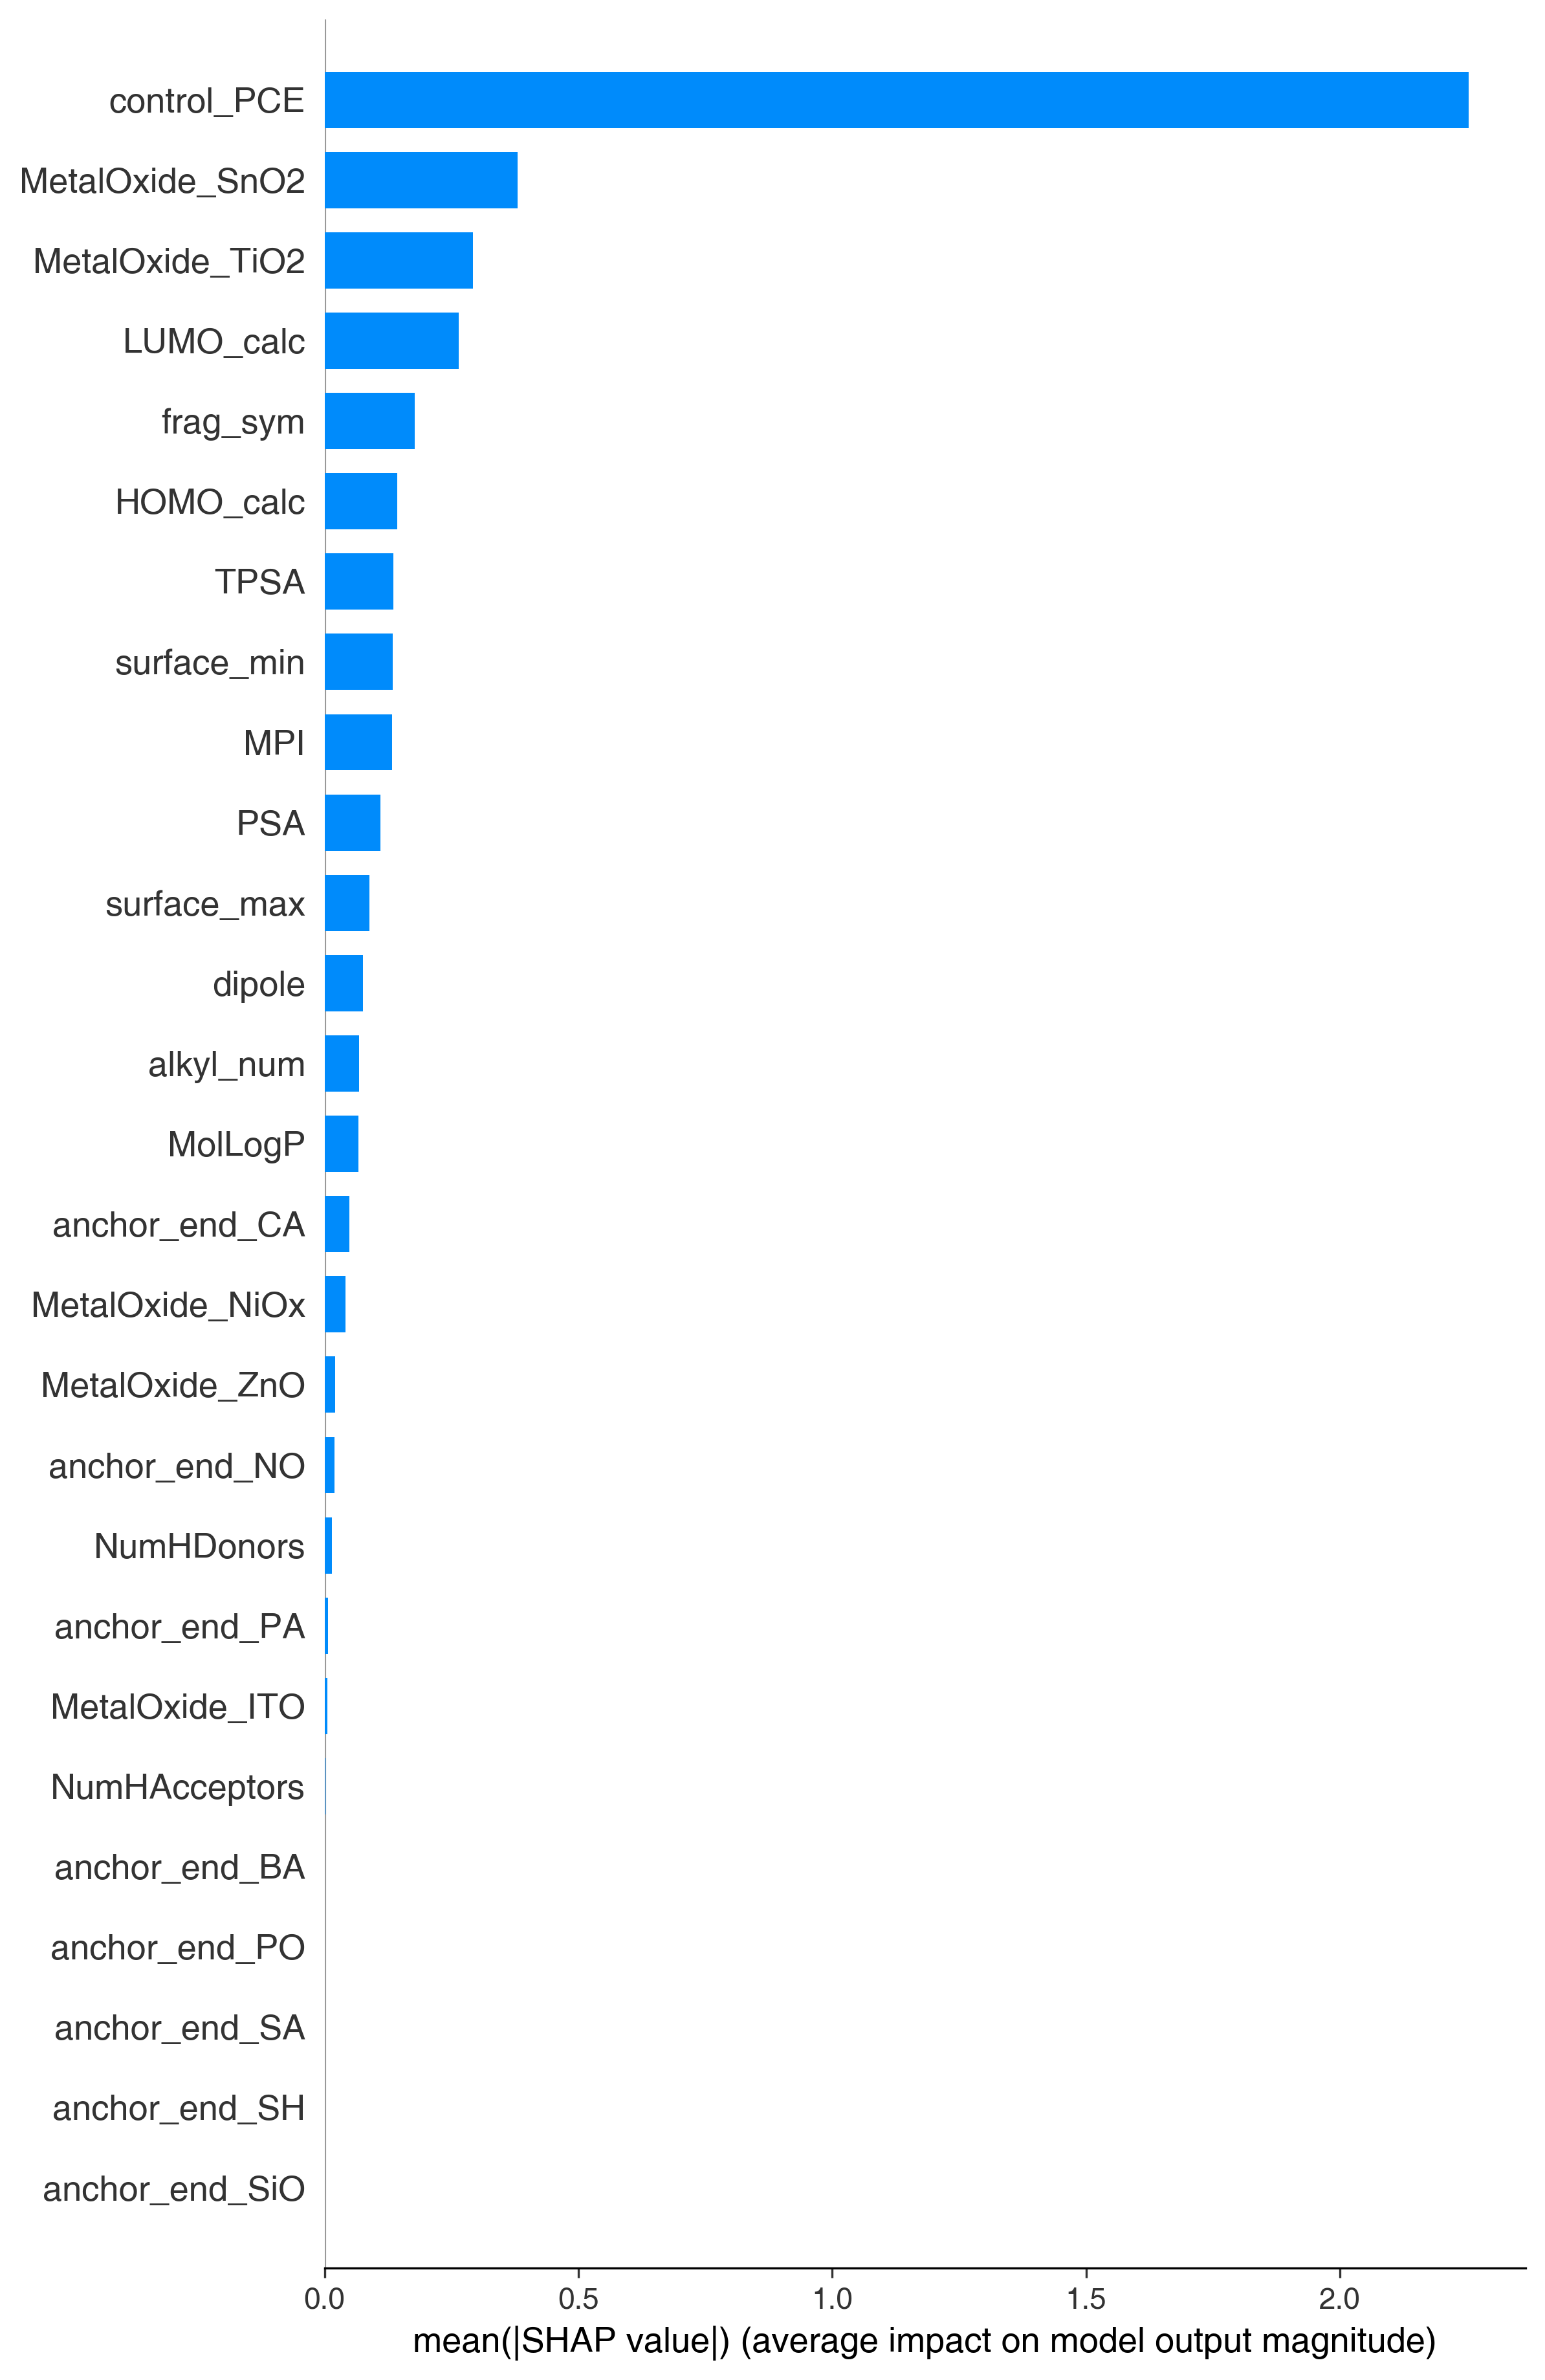

[2.1161055e-03 1.5129596e-02 6.8575062e-02 1.7720099e-01 1.4347225e-01
 2.6490384e-01 7.5939678e-02 1.3264135e-01 1.3408267e-01 8.8722803e-02
 1.3593222e-01 6.7089349e-02 1.1003737e-01 2.2533095e+00 0.0000000e+00
 4.9513195e-02 1.9632593e-02 6.5593380e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4523302e-03 4.1482534e-02 3.8063988e-01
 2.9257411e-01 2.0948026e-02]


In [5]:
shap.summary_plot(shap_value, x, plot_type="bar", max_display=30, show=False)
plt.rcParams.update({
    'figure.figsize': (10, 12),
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'lines.linewidth': 0.75,
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'svg.fonttype': 'none',
    'figure.dpi': 300,
})
ax = plt.gca()
plt.show()
# ax.get_figure().savefig('shap_imp.svg', format='svg', dpi=300)
# ax.get_figure().savefig('shap_imp30.svg', format='svg', dpi=300)
abs_shapvalue = abs(shap_value)
shap_average = np.average(abs_shapvalue,axis=0)
print(shap_average)

<Figure size 1000x1200 with 0 Axes>

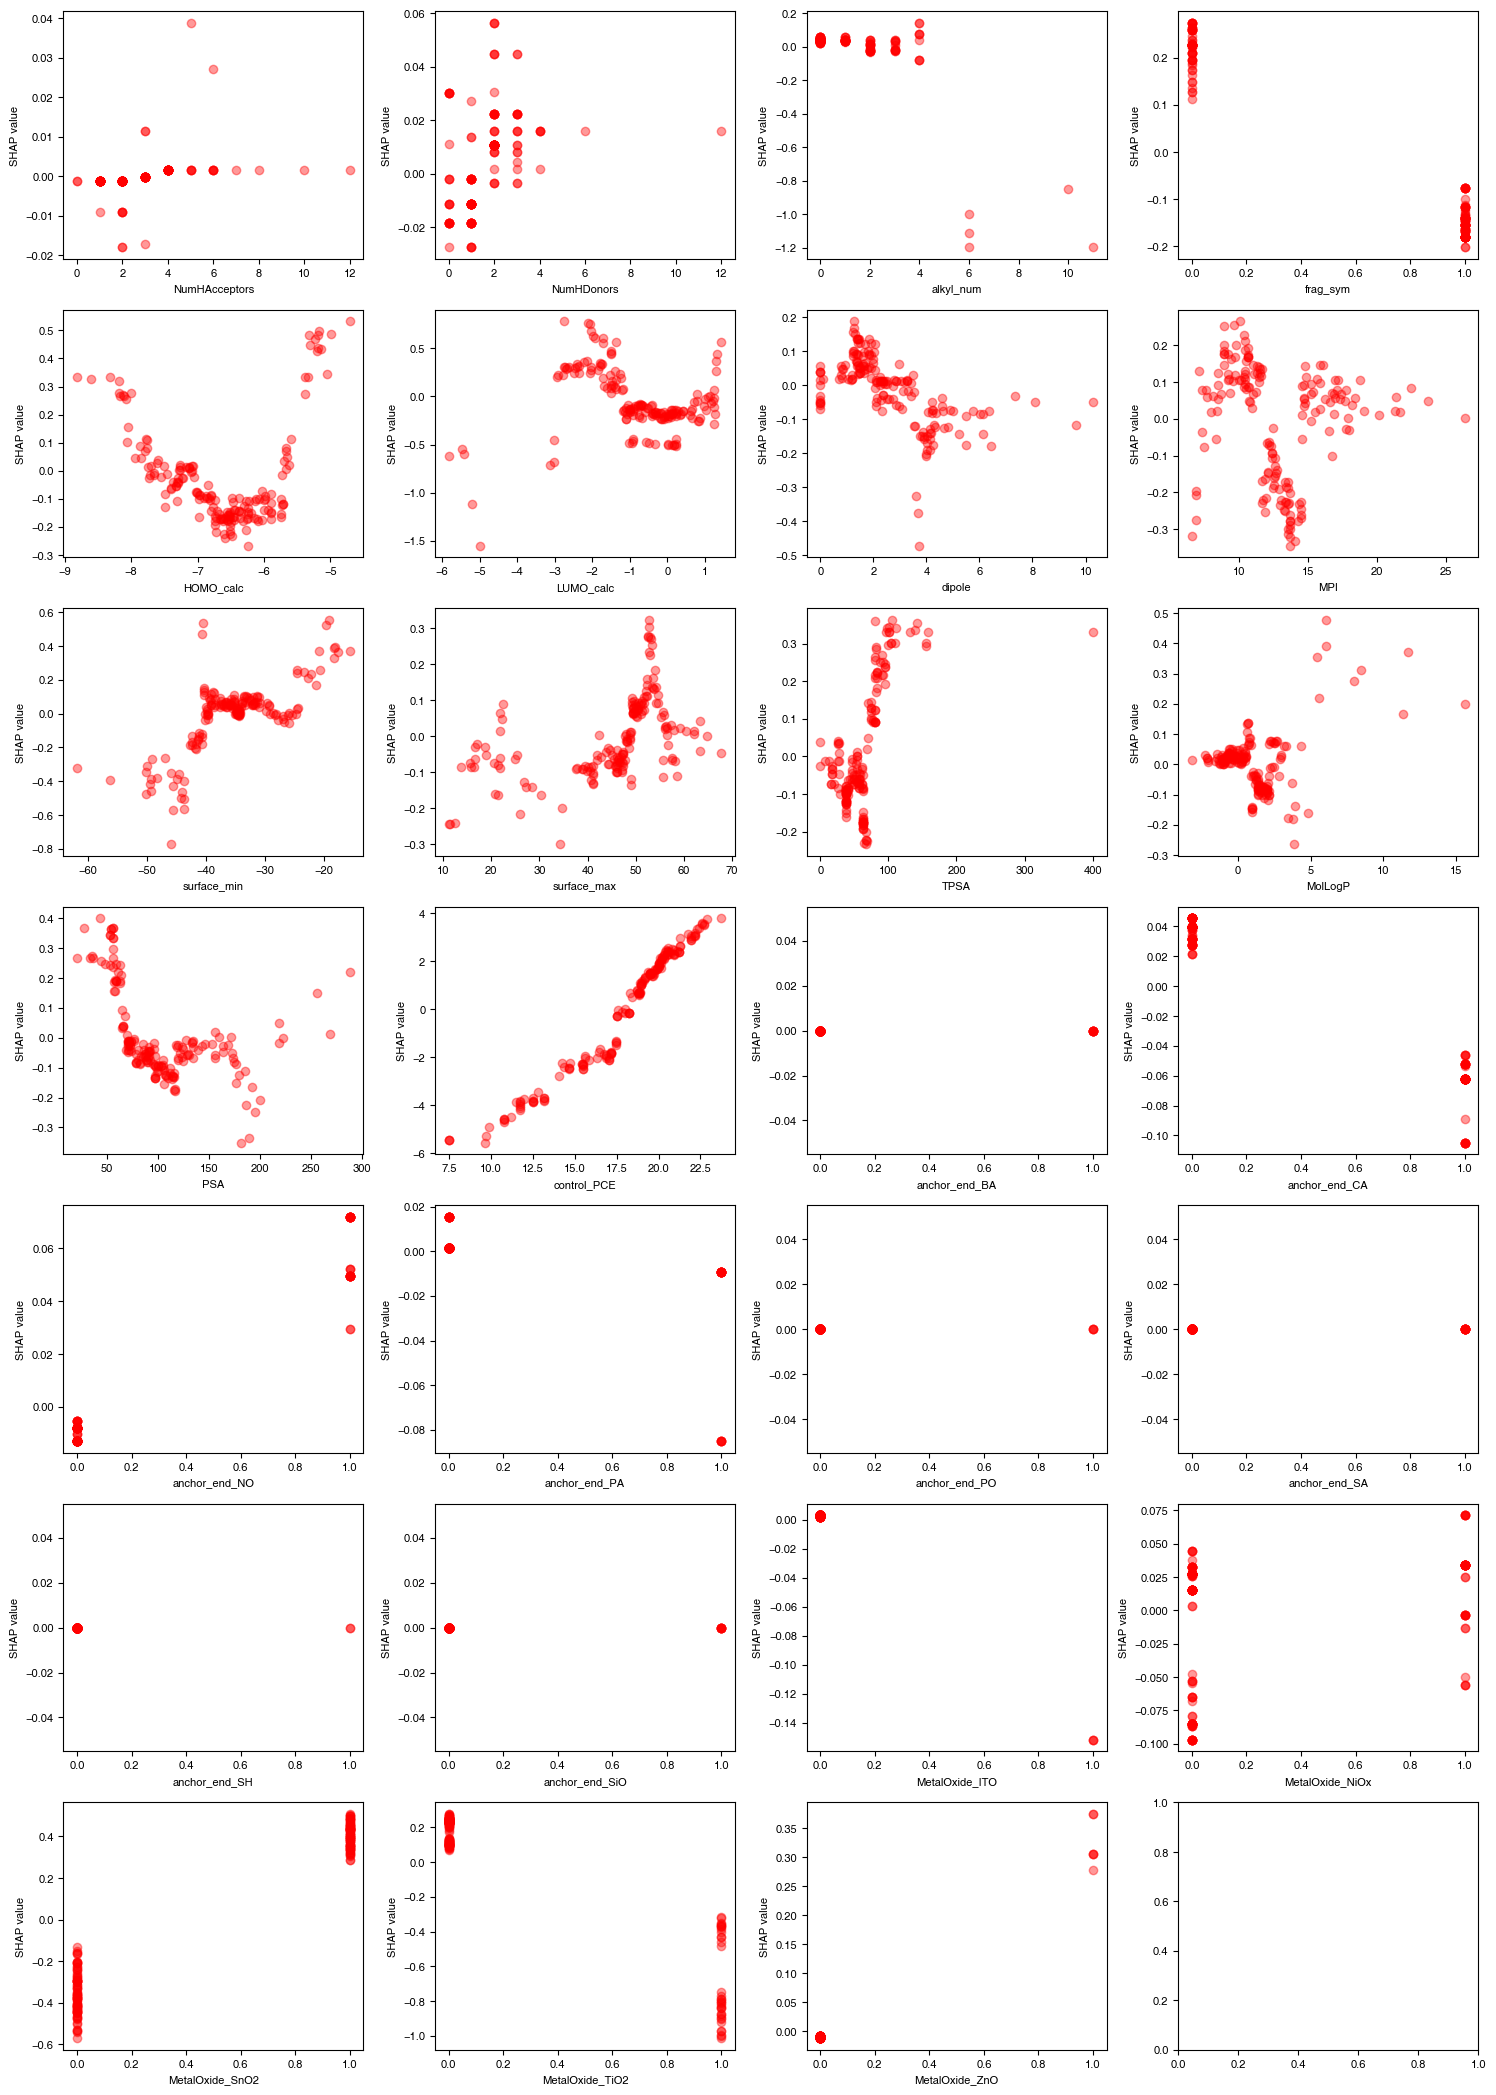

In [8]:
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'lines.linewidth': 0.75,
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'svg.fonttype': 'none',
    'figure.dpi': 100,
})
feature_names = data0.iloc[:,:-1].columns.tolist()
rows = int(np.ceil(len(feature_names)/4))
fig = plt.figure()
fig, axes = plt.subplots(rows, 4, figsize=(15, 3*rows))
for i, feature_name in enumerate(feature_names):
    feature_index = feature_names.index(feature_name)
    specific_shap_values = shap_value[:, feature_index]
    ax = axes[i // 4, i % 4]
    ax.scatter(data0.iloc[:, feature_index], specific_shap_values, color='red',edgecolor=None, alpha=0.4)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('SHAP value')
plt.tight_layout()
plt.show()